In [1]:
from gpaw import GPAW, FermiDirac
from gpaw.wavefunctions.pw import PW
from ase import Atoms
from TDDFT import TDDFT
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

a = 2.5
c = 10
PW_cut=800
nbands=100
atoms = Atoms(symbols='C2', positions=[(0.5 * a, -np.sqrt(3) / 6 * a, 0.5*c),(0.5 * a, np.sqrt(3) / 6 * a, 0.5*c)],
              cell=[(0.5 * a, -0.5 * 3**0.5 * a, 0),
                    (0.5 * a, 0.5 * 3**0.5 * a, 0),
                    (0.0, 0.0, c )], pbc=True)

calc = GPAW(mode=PW(PW_cut),xc='PBE',
            kpts={'size': (12, 12, 1), 'gamma': True},
            setups='sg15',
            occupations=FermiDirac(0.001),
            txt='calc.txt')

atoms.set_calculator(calc)
atoms.get_potential_energy()
calc.diagonalize_full_hamiltonian(nbands=nbands)
calc.write('gs.gpw')

/home/yzhumagulov/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:244: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.ifft(a, n, axis)


In [3]:
tddft=TDDFT(calc)

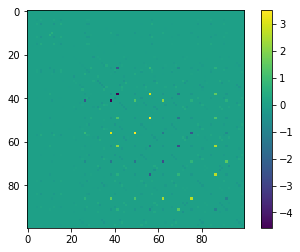

In [4]:
dipole=tddft.get_dipole_matrix()
plt.imshow(dipole[0].real)
plt.colorbar()

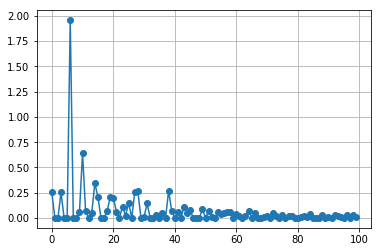

In [5]:
plt.plot(np.abs(dipole[:,:4].sum(axis=(0,1)).real),'-o')
plt.grid()

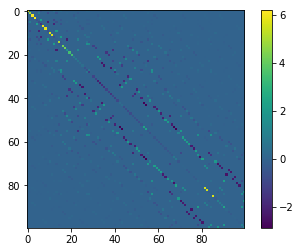

In [6]:
VH_matrix=tddft.get_Hartree_matrix()
plt.imshow(VH_matrix[0].real)
plt.colorbar()

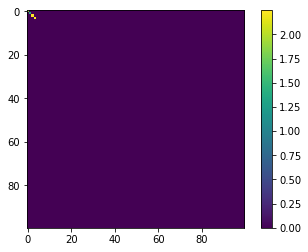

In [7]:
VF_matrix=tddft.get_Fock_matrix()
plt.imshow(VF_matrix[0].real)
plt.colorbar()

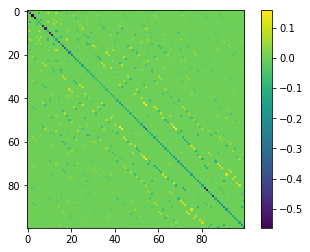

In [8]:
LDAx_matrix=tddft.get_LDA_exchange_matrix()
plt.imshow(LDAx_matrix[0].real)
plt.colorbar()

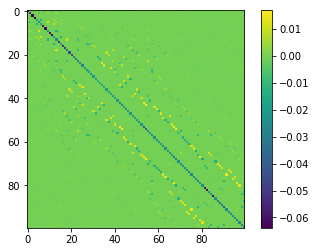

In [9]:
LDAc_matrix=tddft.get_LDA_correlation_matrix()
plt.imshow(LDAc_matrix[0].real)
plt.colorbar()

## Dynamics

In [ ]:
from scipy import linalg

In [ ]:
# can be included to the TDDFT class
def get_H_matrix(wf):
    H_matrix=np.zeros((tddft.NK,tddft.nbands,tddft.nbands),dtype=np.complex128)
    VH_matrix=tddft.get_Hartree_matrix(wf)
    LDAx_matrix=tddft.get_LDA_exchange_matrix(wf)
    LDAc_matrix=tddft.get_LDA_correlation_matrix(wf)
    d_matrix=tddft.get_dipole_matrix(wf)
    for k in range(tddft.NK):
        H_matrix[k] =  np.diag(tddft.EK[k]) + VH_matrix[k] + LDAx_matrix[k] + LDAc_matrix[k] + d_matrix[k] 
    return H_matrix

In [ ]:
# Initialization
wf=np.zeros((tddft.NK,tddft.nbands,tddft.nbands)) 
for k in range(tddft.NK):
    wf[k]=np.eye(tddft.nbands)

H_matrix = get_H_matrix(wf)

In [ ]:
dt=0.01 # timestep
trange = dt*np.arange(10)
NSCsteps = 3 # number of self-consistency steps

for t in trange:
    wf_next=np.copy(wf)

    # self-consistency loop (to be replaced by a self-consitency condition later on)
    for i np.arange(NSCsteps):

        # correction step
        H_matrix_next = get_H_matrix(wf_next)
        H_matrix_midpoint = 0.5*(H_matrix + H_matrix_next) # Eq.(4.25) Ullrich
    
        # prediction step
        for k in range(tddft.NK):
            Hk_left = np.eye(tddft.nbands)+0.5j*dt*H_matrix_midpoint[k]            
            Hk_right = np.eye(tddft.nbands)-0.5j*dt*H_matrix_midpoint[k]
            rhs = Hk_right@wf[k] # right hand side of Eq.(4.24) Ullrich
            wf_next[k]=linalg.solve(Hk_left, rhs)
            
    wf=np.copy(wf_next)            
    H_matrix = np.copy(H_matrix_next)